#### The following notebook walks you thru the steps of Data Cleaning, Data Engneering and EDA.

___

In [1]:
# priting over 1 line of code within the same cell

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [74]:
# importing required libraries
import pandas as pd
import numpy as np
from collections import defaultdict

# Visualization
import missingno
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

# regext
import re

# extra
import warnings
warnings.filterwarnings('ignore')
import random
from collections import Counter

In [124]:
# reading df

df = pd.read_csv('../files/blocks_1.csv')

In [121]:
df.shape
df.info()

(581571, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581571 entries, 0 to 581570
Data columns (total 17 columns):
hash                     581571 non-null object
size                     581571 non-null int64
virtual_size             581571 non-null int64
version                  581571 non-null int64
lock_time                581571 non-null int64
block_hash               581571 non-null object
block_number             581571 non-null int64
block_timestamp          581571 non-null datetime64[ns]
block_timestamp_month    581571 non-null datetime64[ns]
input_count              581571 non-null int64
output_count             581571 non-null int64
input_value              581571 non-null float64
output_value             581571 non-null float64
is_coinbase              581571 non-null bool
fee                      581571 non-null float64
inputs                   581571 non-null object
outputs                  581571 non-null object
dtypes: bool(1), datetime64[ns](2), float64(3), int64(7), objec

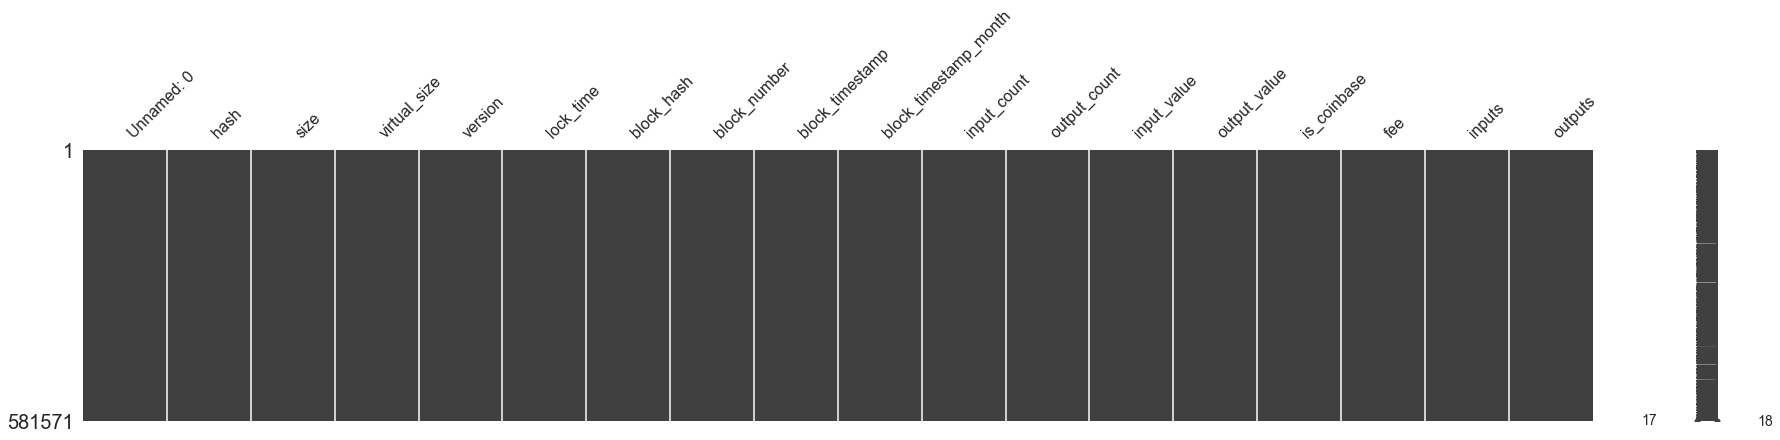

In [5]:
# checking if there are missing values

missingno.matrix(df, figsize = (30,5)) # no missing values
#missingno.matrix(df_1, figsize = (30,5)) # no missing values

In [102]:
# taking into account that tx that were recently mined have outputs but no inputs its clear that 
# there will be empty values in the input_value column.

nulls_percent_df = pd.DataFrame(df.isna().sum()/len(df)).reset_index()
nulls_percent_df.columns = ['column_name', 'nulls_percentage']
nulls_percent_df['amount']= list(df.isna().sum())
nulls_percent_df

,column_name,nulls_percentage,amount
0,hash,0.0,0
1,size,0.0,0
2,virtual_size,0.0,0
3,version,0.0,0
4,lock_time,0.0,0
5,block_hash,0.0,0
6,block_number,0.0,0
7,block_timestamp,0.0,0
8,block_timestamp_month,0.0,0
9,input_count,0.0,0


In [7]:
# precisely... They are all coinbase tx aka. recently mined tx that got a reward

len(df[df['is_coinbase']== True])

276

<br>

#### Let's do some data exploration and data cleaning.

___

In [85]:
df.describe()

,size,virtual_size,version,lock_time,block_number,input_count,output_count,input_value,output_value,fee
count,581571.000000,581571.000000,581571.000000,5.815710e+05,581571.000000,581571.000000,581571.000000,5.812950e+05,5.815710e+05,5.815710e+05
mean,625.356890,472.533584,1.384670,7.283455e+05,679388.701950,2.865406,3.621744,6.337607e+08,6.337565e+08,5.096711e+04
std,3548.191362,2518.243799,0.486518,2.928051e+07,80.434608,19.310561,18.395188,1.936682e+10,1.936222e+10,2.624340e+05
min,187.000000,109.000000,1.000000,0.000000e+00,679250.000000,0.000000,1.000000,2.441000e+03,0.000000e+00,0.000000e+00
25%,223.000000,166.000000,1.000000,0.000000e+00,679321.000000,1.000000,1.000000,4.398060e+05,4.133160e+05,1.592100e+04
50%,226.000000,223.000000,1.000000,0.000000e+00,679387.000000,1.000000,2.000000,1.781026e+06,1.755340e+06,2.305200e+04
75%,373.000000,257.000000,2.000000,0.000000e+00,679460.000000,1.000000,2.000000,1.622443e+07,1.623662e+07,3.390000e+04
max,224446.000000,143109.000000,2.000000,4.224846e+09,679525.000000,1351.000000,4327.000000,1.272682e+12,1.272681e+12,2.191089e+07


In [8]:
# visualizing the df

df.head()

,Unnamed: 0,hash,size,virtual_size,version,lock_time,block_hash,block_number,block_timestamp,block_timestamp_month,input_count,output_count,input_value,output_value,is_coinbase,fee,inputs,outputs
0,0,9af5040f4be5c012d6c8488082f13076b7284035d7cbea...,370,370,2,0,00000000000000000001732fd87b83d81424376b900ef2...,679250,2021-04-14 23:51:48+00:00,2021-04-01,2,2,261486.0,225320.0,False,36166.0,"[{'index': 0, 'spent_transaction_hash': 'cce4e...","[{'index': 0, 'script_asm': 'OP_HASH160 c9e274..."
1,1,991a1d1239096f047bfaf85872b2e5a2fad43573b56878...,223,223,1,0,00000000000000000001732fd87b83d81424376b900ef2...,679250,2021-04-14 23:51:48+00:00,2021-04-01,1,2,536063.0,518661.0,False,17402.0,"[{'index': 0, 'spent_transaction_hash': '13a89...","[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
2,2,5affa0d36a786c29eea5365b5bbf3ebdcf16abd657f02e...,418,256,2,679186,00000000000000000001732fd87b83d81424376b900ef2...,679250,2021-04-14 23:51:48+00:00,2021-04-01,2,2,1807160.0,1786680.0,False,20480.0,"[{'index': 0, 'spent_transaction_hash': 'f5609...","[{'index': 0, 'script_asm': 'OP_HASH160 84dcb2..."
3,3,148f6302efb4c3f8243f07cd504ab8f3c58094da932f3d...,1786,982,2,679183,00000000000000000001732fd87b83d81424376b900ef2...,679250,2021-04-14 23:51:48+00:00,2021-04-01,10,2,9608365.0,9529805.0,False,78560.0,"[{'index': 0, 'spent_transaction_hash': '7582d...","[{'index': 0, 'script_asm': 'OP_HASH160 c01a0d..."
4,4,45b10143794774fad5e573a27a8273f94a8d13e44986b3...,420,258,2,679186,00000000000000000001732fd87b83d81424376b900ef2...,679250,2021-04-14 23:51:48+00:00,2021-04-01,2,2,1802541.0,1781901.0,False,20640.0,"[{'index': 0, 'spent_transaction_hash': '22e1d...","[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."


### Columns Description:

- |__Unnamed: 0__| -> Redundant column of the index. _'int64'_
- |__Hash__| -> The hash of this transaction. _'object'_
- |__Size__| -> The size of block data in bytes. _'int64'_
- |__Virtual size__| -> The virtual transaction size (differs from size for witness transactions). _'int64'_
- |__Version__| -> Protocol version specified in block which contained this transaction. _'object'_
- |__Lock time__| -> Earliest time that miners can include the transaction in their hashing of the Merkle root to attach it in the latest. _'object'_
- |__Block hash__| -> Hash of the block which contains this transaction. _'int64'_
- |__Block number__| -> Number of the block which contains this transaction. _'int64'_
- |__block timestamp__| -> Timestamp of the block which contains this transaction. _'object'_
- |__Block timestamp month__| -> Month of the block which contains this transaction. _'int64'_
- |__Input count__| -> The number of inputs in the transaction. _'int64'_
- |__Output count__| -> The number of outputs in the transaction. _'int64'_
- |__Input value__| -> Total value of inputs in the transaction in satoshis. _'int64'_
- |__Output value__| -> Total value of outputs in the transaction in satoshis. _'int64'_
- |__Is coinbase__| -> Max amount of sets that can be played in a match. _'bool'_
- |__Fee__| -> The fee paid by this transaction in sats. _'float64'_
- |__Inputs__| -> Transaction inputs. _'object'_
- |__Outputs__| -> Transaction outputs. _'object'_

<br>

#### Checking all columns and changing the type in case it's needed

In [9]:
# index column and Unnamed

df.index
df['Unnamed: 0']

RangeIndex(start=0, stop=581571, step=1)

0              0
1              1
2              2
3              3
4              4
           ...  
581566    581566
581567    581567
581568    581568
581569    581569
581570    581570
Name: Unnamed: 0, Length: 581571, dtype: int64

In [10]:
# dropping redundant columns

df.drop(columns= 'Unnamed: 0', inplace= True)

<br>

In [11]:
# hash column

df.hash[random.randint(0,len(df))]

'2710c76ccb7becc2237ab69ceaecf50b252567ae79794c7093e7e6619419f74e'

In [12]:
df.hash.duplicated().sum()

0

<br>

In [13]:
# size column and vsize column should be very similar

df['size'].value_counts()

223      54198
225      46614
224      38136
226      36917
192      24445
         ...  
87252        1
19703        1
9681         1
14072        1
7938         1
Name: size, Length: 9522, dtype: int64

In [14]:
len(df)/100


5815.71

In [15]:
df['size'].min()
df['size'].max()

187

224446

In [16]:
df_rep = df.groupby("size").filter(lambda x: len(x) > len(df)/100)

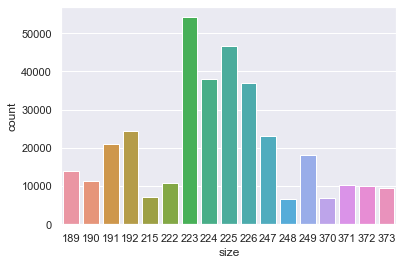

In [17]:
sns.countplot(x= 'size', data= df_rep)

In [18]:
# tx with very large size prolly exchanges moving large amount of funds from one cold wallet to the another.

len(df[df['size'] > 200000])
df[df['size'] > 200000].head()

8

,hash,size,virtual_size,version,lock_time,block_hash,block_number,block_timestamp,block_timestamp_month,input_count,output_count,input_value,output_value,is_coinbase,fee,inputs,outputs
235013,2f6e8b2f3f0502fbe45048a15f20c9d625694bc3ce0389...,224441,99577,1,0,00000000000000000003b7b038b43fce6afbec0a25e055...,679361,2021-04-15 16:45:46+00:00,2021-04-01,762,1,9.357375e+08,9.249485e+08,False,10788984.0,"[{'index': 0, 'spent_transaction_hash': 'b44fa...","[{'index': 0, 'script_asm': '0 6fe7cd91eedcf8d..."
236325,263042dcadda50a8425abee3f81bb1b260e307bfef0619...,224445,99578,1,0,00000000000000000007e2bf845c91e4f2075c103e50f2...,679362,2021-04-15 16:50:16+00:00,2021-04-01,762,1,1.178045e+09,1.167356e+09,False,10689086.0,"[{'index': 0, 'spent_transaction_hash': '2287f...","[{'index': 0, 'script_asm': '0 39cdbdeacf2022b..."
239051,3e29023415e4563c9c2c1cf2416d1fe78e49013ab0a14f...,224446,99578,1,0,000000000000000000056c560a61300495d063aad5a7f6...,679363,2021-04-15 16:50:09+00:00,2021-04-01,762,1,8.614512e+08,8.514614e+08,False,9989800.0,"[{'index': 0, 'spent_transaction_hash': '2bb93...","[{'index': 0, 'script_asm': '0 fc5c7ae2b222a8c..."
239410,56297cc879ff2795dbaf3244b50f7da18594c2d250faba...,224442,99577,1,0,000000000000000000056c560a61300495d063aad5a7f6...,679363,2021-04-15 16:50:09+00:00,2021-04-01,762,1,1.059856e+09,1.049866e+09,False,9989800.0,"[{'index': 0, 'spent_transaction_hash': 'c3c9b...","[{'index': 0, 'script_asm': '0 3d497e0b6d34575..."
297884,c54b62009d9055cd70328bacbc404a38ff37032be3ada0...,224444,99578,1,0,00000000000000000005a2db60197fa9012b70f75e4745...,679391,2021-04-15 19:40:00+00:00,2021-04-01,762,1,1.553114e+09,1.549418e+09,False,3696226.0,"[{'index': 0, 'spent_transaction_hash': 'ec36d...","[{'index': 0, 'script_asm': '0 3ff1cc6b693c388..."


<br>

In [19]:
# version - most nodes are using the version 1

df['version'].value_counts()

1    357858
2    223713
Name: version, dtype: int64

<br>

In [20]:
# locktime

df['lock_time'].value_counts()

0             458923
679298          2847
679358          2230
679326          1896
679493          1668
               ...  
678940             1
539491602          1
548994517          1
3948938955         1
1027916155         1
Name: lock_time, Length: 990, dtype: int64

In [87]:
df['lock_time'].mean()
df['lock_time'].max()

728345.5334722673

4224845937

In [21]:
df[df['lock_time'] > 679298].head()a

,hash,size,virtual_size,version,lock_time,block_hash,block_number,block_timestamp,block_timestamp_month,input_count,output_count,input_value,output_value,is_coinbase,fee,inputs,outputs
512,38b10a1ee7fc660fbccbead4c0995dca4437f85401a23e...,346,181,2,550279849,00000000000000000001732fd87b83d81424376b900ef2...,679250,2021-04-14 23:51:48+00:00,2021-04-01,1,2,1000000.0,985716.0,False,14284.0,"[{'index': 0, 'spent_transaction_hash': '401d6...","[{'index': 0, 'script_asm': '0 bdfb2771408530b..."
1106,eb9be95c29c9e2921796c412eaa47ef0e4c1dd02f05c13...,346,181,2,552497974,00000000000000000001732fd87b83d81424376b900ef2...,679250,2021-04-14 23:51:48+00:00,2021-04-01,1,2,5000000.0,4986042.0,False,13958.0,"[{'index': 0, 'spent_transaction_hash': '877b1...","[{'index': 0, 'script_asm': '0 a32fe0695ac9dec..."
1810,0260767efb3f0ed0f5194a772a50bda9199f88d999778d...,345,180,2,543901113,00000000000000000001732fd87b83d81424376b900ef2...,679250,2021-04-14 23:51:48+00:00,2021-04-01,1,2,1000000.0,985683.0,False,14317.0,"[{'index': 0, 'spent_transaction_hash': '5d5f9...","[{'index': 0, 'script_asm': '0 4b124c4fe7d0046..."
3423,85d81281dc345e821b1fbf7fd0f0754cdf7d712c8670f2...,362,335,1,3867082828,0000000000000000000036b25c65b75f3f6c103faaf47f...,679251,2021-04-15 00:07:53+00:00,2021-04-01,0,4,NaN,742947707.0,True,0.0,[],"[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."
6820,2cc4ffe94c1b68b23c74a2b59100605e434b8eb41be790...,362,335,1,3567522739,00000000000000000009038889e27eaf247aba6e3f6bd6...,679253,2021-04-15 00:19:03+00:00,2021-04-01,0,4,NaN,724546576.0,True,0.0,[],"[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160..."


<br>

In [22]:
# blockhash --- nothing here i guess

df.block_hash.head()

0    00000000000000000001732fd87b83d81424376b900ef2...
1    00000000000000000001732fd87b83d81424376b900ef2...
2    00000000000000000001732fd87b83d81424376b900ef2...
3    00000000000000000001732fd87b83d81424376b900ef2...
4    00000000000000000001732fd87b83d81424376b900ef2...
Name: block_hash, dtype: object

<br>

In [25]:
# there are approx 7k tx per block... and 1 block is mined approx every 10 min

df['block_number'].min()
df['block_number'].max()
(df['block_number'].max() - df['block_number'].min())

679250

679525

275

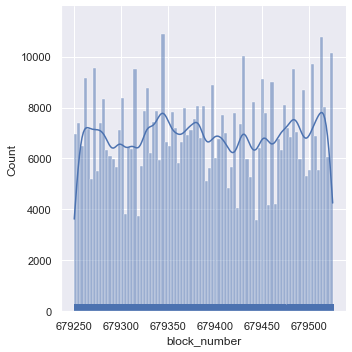

In [24]:
sns.displot(data=df, x='block_number', kde= True, rug=True)

<br>

In [27]:
# converting to proper type block_timestamp

df['block_timestamp']= pd.to_datetime(df.block_timestamp).dt.tz_localize(None)

In [28]:
df['block_timestamp'].min()
df['block_timestamp'].max()

Timestamp('2021-04-14 23:51:48')

Timestamp('2021-04-16 23:57:57')

<br>

In [46]:
# check this column more in depth

df['block_timestamp_month'] = pd.to_datetime(df['block_timestamp_month'])

In [47]:
df['block_timestamp_month'].head()

0   2021-04-01
1   2021-04-01
2   2021-04-01
3   2021-04-01
4   2021-04-01
Name: block_timestamp_month, dtype: datetime64[ns]

<br>

In [69]:
# big majority of tx have 2 inputs

len(df['input_count'].value_counts())

600

In [73]:
print(len(df[df['input_count'] < 5]),'/',len(df))

552079 / 581571


In [67]:
a= [i  if i < 6 else 6 for i in df['input_count']]
Counter(a)

Counter({2: 76354, 1: 442118, 6: 23128, 4: 10547, 3: 22784, 5: 6364, 0: 276})

In [54]:
df['input_count'].value_counts(normalize= True)[:5]

1    0.760213
2    0.131289
3    0.039177
4    0.018135
5    0.010943
Name: input_count, dtype: float64

<br>

In [75]:
# same happens with output... unless the UTXO is spent completely most outputs are 2 cuz of the change address
# prolly very big numbers of inputs/outputs come from mixers or exchanges

df['output_count'].value_counts()

2      363616
1      154649
3       20433
4        7712
5        4700
        ...  
281         1
283         1
286         1
294         1
301         1
Name: output_count, Length: 338, dtype: int64

<br>

In [81]:
# amount of money sent in satoshis ! 

df['input_value'].describe()

count    5.812950e+05
mean     6.337607e+08
std      1.936682e+10
min      2.441000e+03
25%      4.398060e+05
50%      1.781026e+06
75%      1.622443e+07
max      1.272682e+12
Name: input_value, dtype: float64

In [101]:
df['input_value'].fillna(0, inplace= True)

In [103]:
df['input_value'].min()
df['input_value'].max()

0.0

1272681684153.0

<br>

In [23]:
|Output value| -> Total value of outputs in the transaction in satoshis. 'int64'
|Is coinbase| -> Max amount of sets that can be played in a match. 'bool'
|Fee| -> The fee paid by this transaction in sats. 'float64'
|Inputs| -> Transaction inputs. 'object'
|Outputs| -> Transaction outputs. 'object'

SyntaxError: invalid syntax (<ipython-input-23-d707560f1750>, line 1)

In [104]:
df['output_value'].describe()

count    5.815710e+05
mean     6.337565e+08
std      1.936222e+10
min      0.000000e+00
25%      4.133160e+05
50%      1.755340e+06
75%      1.623662e+07
max      1.272681e+12
Name: output_value, dtype: float64

In [126]:
df['outputs'][0]

"[{'index': 0, 'script_asm': 'OP_HASH160 c9e274be5efd03e357b0d3f50baeee88203ef9fb OP_EQUAL', 'script_hex': 'a914c9e274be5efd03e357b0d3f50baeee88203ef9fb87', 'required_signatures': 1.0, 'type': 'scripthash', 'addresses': array(['3L6V2YR6vLAnuq5SAtuC9u3Ehh9uc8GeA7'], dtype=object), 'value': Decimal('192900.000000000')}\n {'index': 1, 'script_asm': 'OP_DUP OP_HASH160 7891797f11371b5b8e077f3f1db93a9ea893bb3b OP_EQUALVERIFY OP_CHECKSIG', 'script_hex': '76a9147891797f11371b5b8e077f3f1db93a9ea893bb3b88ac', 'required_signatures': 1.0, 'type': 'pubkeyhash', 'addresses': array(['1BzWMmm59sbWhZ3NftKUZAAGSxH5LEsDyw'], dtype=object), 'value': Decimal('32420.000000000')}]"

In [110]:
def clean_txs(x):
    
    if x == "[]":
        return x
    chars_to_replace = "[{'}]\n( "

    words_to_replace = ["array", "dtype=object", "Decimal", ")index"]

    
    for char in chars_to_replace:
        x = x.replace(char, "")

    for word in words_to_replace:
        x = x.replace(word, "")
        
    x = x.replace(")", "")

    inputs_dict = defaultdict(list)
    problematic_text = x.split(":")
    inputs_dict[problematic_text[0]].append(problematic_text[1][0])
    for i, rep in enumerate(problematic_text):
        if i == 0:
            continue
        rep = rep.split(",")
        
        if i == 1:
            last_rep = rep[1]
            #inputs_dict[last_thing] = []
        else:
            try:
                rep[0] = int(rep[0])
            except ValueError:
                pass
            
            inputs_dict[last_rep].append(rep[0])
            try:
                last_rep = rep[1]
            except IndexError as error:
                inputs_dict["values"].append(rep[0])

    inputs_dict["index"] = list(range(len(inputs_dict["required_signatures"])))
    inputs_dict["values"] = [float(value.replace("E", "e").split(".")[0]) for value in inputs_dict["values"]]
    
    return inputs_dict

In [111]:
df["inputs"] = df["inputs"].apply(clean_txs)
df["outputs"] = df["outputs"].apply(clean_txs)

In [132]:
df['inputs'][0]

"[{'index': 0, 'spent_transaction_hash': 'cce4e1902bd8049164c3ffad24effc41afab8785ae9eb92dca0b5fcb752d64f6', 'spent_output_index': 3, 'script_asm': '30440220350728e351cecac769b9109ffa6c3901e5c76c4fa835460bb378ce851702a57902206983b2be92695e155e4d727375b3912a596523dcb832f298d14efd44cc9c30c1[ALL] 025028009d38da120a16b09f9443b176a00a7a65f4ccb575e3f1e03fd2225e9b6b', 'script_hex': '4730440220350728e351cecac769b9109ffa6c3901e5c76c4fa835460bb378ce851702a57902206983b2be92695e155e4d727375b3912a596523dcb832f298d14efd44cc9c30c10121025028009d38da120a16b09f9443b176a00a7a65f4ccb575e3f1e03fd2225e9b6b', 'sequence': 4294967295, 'required_signatures': 1, 'type': 'pubkeyhash', 'addresses': array(['1BzWMmm59sbWhZ3NftKUZAAGSxH5LEsDyw'], dtype=object), 'value': Decimal('260040.000000000')}\n {'index': 1, 'spent_transaction_hash': 'ff9c43bcf01ddbf077e191391d21ebdf30fc9c630533b26540cba1f8e5f2bb7e', 'spent_output_index': 1, 'script_asm': '304402200a1c97d069e9be4db0ebc7181659b5423e508dd07ce500ff56eda47b2676ed030

In [122]:
df['inputs'][0]
df['inputs'][0].keys()

defaultdict(list,
            {'index': [0, 1],
             'spent_transaction_hash': ['cce4e1902bd8049164c3ffad24effc41afab8785ae9eb92dca0b5fcb752d64f6',
              'ff9c43bcf01ddbf077e191391d21ebdf30fc9c630533b26540cba1f8e5f2bb7e'],
             'spent_output_index': [3, 1],
             'script_asm': ['30440220350728e351cecac769b9109ffa6c3901e5c76c4fa835460bb378ce851702a57902206983b2be92695e155e4d727375b3912a596523dcb832f298d14efd44cc9c30c1ALL025028009d38da120a16b09f9443b176a00a7a65f4ccb575e3f1e03fd2225e9b6b',
              '304402200a1c97d069e9be4db0ebc7181659b5423e508dd07ce500ff56eda47b2676ed0302204c28d227160668c183a315906d5c92bc9418d38f8f7d03f6a25b59eb6049cf26ALL025028009d38da120a16b09f9443b176a00a7a65f4ccb575e3f1e03fd2225e9b6b'],
             'script_hex': ['4730440220350728e351cecac769b9109ffa6c3901e5c76c4fa835460bb378ce851702a57902206983b2be92695e155e4d727375b3912a596523dcb832f298d14efd44cc9c30c10121025028009d38da120a16b09f9443b176a00a7a65f4ccb575e3f1e03fd2225e9b6b',
     

dict_keys(['index', 'spent_transaction_hash', 'spent_output_index', 'script_asm', 'script_hex', 'sequence', 'required_signatures', 'type', 'addresses', '', 'values'])

In [123]:
df['outputs'][0]
df['outputs'][0].keys()

defaultdict(list,
            {'index': [0, 1],
             'script_asm': ['OP_HASH160c9e274be5efd03e357b0d3f50baeee88203ef9fbOP_EQUAL',
              'OP_DUPOP_HASH1607891797f11371b5b8e077f3f1db93a9ea893bb3bOP_EQUALVERIFYOP_CHECKSIG'],
             'script_hex': ['a914c9e274be5efd03e357b0d3f50baeee88203ef9fb87',
              '76a9147891797f11371b5b8e077f3f1db93a9ea893bb3b88ac'],
             'required_signatures': ['1.0', '1.0'],
             'type': ['scripthash', 'pubkeyhash'],
             'addresses': ['3L6V2YR6vLAnuq5SAtuC9u3Ehh9uc8GeA7',
              '1BzWMmm59sbWhZ3NftKUZAAGSxH5LEsDyw'],
             '': ['192900.000000000', 1, '32420.000000000'],
             'values': [192900.0, 32420.0]})

dict_keys(['index', 'script_asm', 'script_hex', 'required_signatures', 'type', 'addresses', '', 'values'])